<a href="https://colab.research.google.com/github/victorphd/aa/blob/master/tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Deep Learning Pipeline


---

In this notebook, we’ll walk through an end-to-end pipeline for a classification task on the MNIST dataset.

We will implement the following steps - 

0.   Download data
1.   Load and Preprocess dataset
2.   Define the model, loss function, optimizer and evaluation metric
3.   Train loop
4.   Evaluate results


# Part 0: Download Data

In [0]:
!pip install pypng

     |████████████████████████████████| 296kB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/a4/cd/54/c1d0803dfed5adf2bba530eda161581d9096d0154aee082cac
Successfully built pypng


In [0]:
import tensorflow as tf
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gunzip t*.gz

--2019-05-03 20:46:15--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  27.7MB/s    in 0.3s    

2019-05-03 20:46:16 (27.7 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2019-05-03 20:46:16--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.20K  --.-KB/s    in 0.03s   

2019-05-03 20:46:17 (818 KB/s) - ‘train-labels-id

In [0]:
# source: https://github.com/myleott/mnist_png/blob/master/convert_mnist_to_png.py
import os
import struct
import sys

from array import array
from os import path

import png

# source: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
def read(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array("B", fimg.read())
    fimg.close()

    return lbl, img, size, rows, cols

def write_dataset(labels, data, size, rows, cols, output_dir):
    # create output directories
    output_dirs = [
        path.join(output_dir, str(i))
        for i in range(10)
    ]
    for dir in output_dirs:
        if not path.exists(dir):
            os.makedirs(dir)

    # write data
    for (i, label) in tqdm(enumerate(labels)):
        output_filename = path.join(output_dirs[label], str(i) + ".png")
        with open(output_filename, "wb") as h:
            w = png.Writer(cols, rows, greyscale=True)
            data_i = [
                data[ (i*rows*cols + j*cols) : (i*rows*cols + (j+1)*cols) ]
                for j in range(rows)
            ]
            w.write(h, data_i)

input_path = '/content'
output_path = '/content/mnist'
for dataset in ["training", "testing"]:
    labels, data, size, rows, cols = read(dataset, input_path)
    write_dataset(labels, data, size, rows, cols,
                  path.join(output_path, dataset))

# 1. Load and Preprocess Dataset











In [0]:
params = {
    'learning_rate': 0.01,
    'hidden_units': 10,
    'save_summary_steps': 100,
    'num_epochs': 5,
    'train_size': 60000,
    'test_size': 10000,
    'batch_size': 100,
}

In [0]:
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

def get_image_paths_and_labels(root):
    all_image_paths = list(root.glob('*/*'))
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths)
    
    label_names = sorted(int(item.name) for item in root.glob('*/') if item.is_dir())
    label_to_index = dict((name, index) for index,name in enumerate(label_names))
    all_image_labels = [label_to_index[int(pathlib.Path(path).parent.name)]
                        for path in all_image_paths]
    return all_image_paths, all_image_labels

train_root = pathlib.Path('mnist/training')
test_root = pathlib.Path('mnist/testing')
train_image_paths, train_image_labels = get_image_paths_and_labels(train_root)
test_image_paths, test_image_labels = get_image_paths_and_labels(test_root)

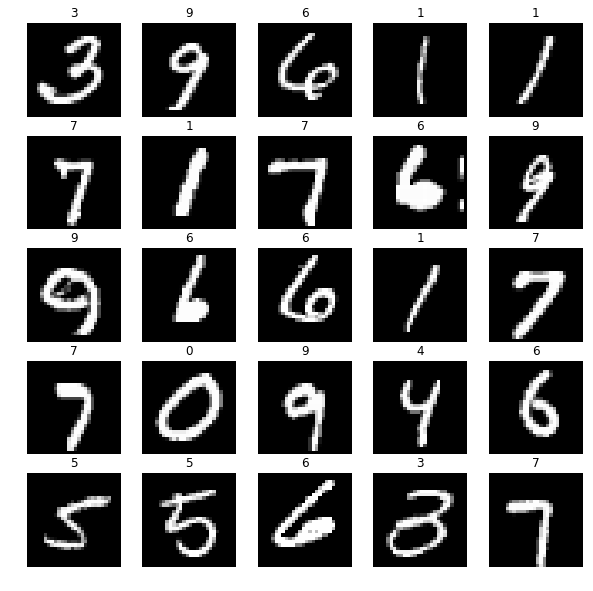

In [0]:
'''
We first verify that the dataset was loaded correctly
by viewing the images using opencv
'''

def view_dataset(paths, labels, method='cv2'):
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    flatted_axs = [item for one_ax in axs for item in one_ax]
    for ax, path, label in zip(flatted_axs, paths[:25], labels[:25]):
        if method == 'cv2':
            img = cv2.imread(path, 3)
        elif method == 'tf':
            img = try_tf_image(path)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show() 

view_dataset(train_image_paths, train_image_labels)

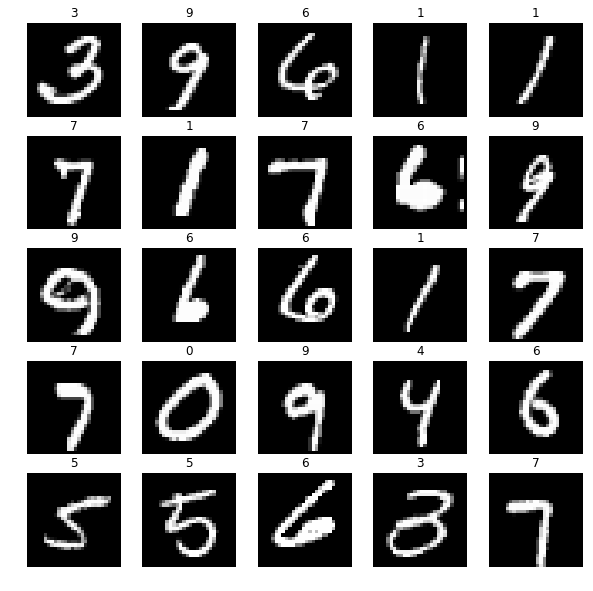

In [0]:
'''
Now, we build the tf preprocessing pipeline and
verify that it looks correct!
'''
def preprocess_image(image):
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize_images(image, [28, 28])
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

def try_tf_image(image_path):
    with tf.Session() as sess:
        img_tensor = load_and_preprocess_image(image_path)
        img = sess.run(img_tensor)
        return img
    
view_dataset(train_image_paths, train_image_labels, method='tf')

    

In [0]:
'''
Question1: What would you need to do if the preprocess step 
           involves data augmentation?
Question2: How does this differ from the feed_dict method?
           Which method should be preferred?
'''
def get_ds(image_paths, image_labels, batch_size):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(image_labels)
    
    # load and preprocess images
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=4)
    
    # create dataset, batch and prefetch
    # prefetch is for computational efficiency
    # see https://www.tensorflow.org/guide/performance/datasets
    image_label_ds = (tf.data.Dataset.zip((image_ds, label_ds))
                        .batch(batch_size)
                        .prefetch(1))
    
    # tensorflow dataset iterator to iterate over dataset
    iterator = image_label_ds.make_initializable_iterator()
    
    # get next images and labels
    images, labels = iterator.get_next()
    
    # op to reinit the iterator
    iterator_init_op = iterator.initializer

    inputs = {'images': images, 'labels': labels, 'iterator_init_op': iterator_init_op}
    return inputs

train_inputs = get_ds(train_image_paths, train_image_labels, batch_size=params['batch_size'])
test_inputs = get_ds(test_image_paths, test_image_labels, batch_size=params['batch_size'])

# 2. Define the model, loss function, optimizer and evaluation metric

In [0]:
# source: https://github.com/cs230-stanford/cs230-code-examples/blob/master/tensorflow/vision/model/model_fn.py
def build_model(is_training, inputs, params):
    images = inputs['images']
    out = images
    out = tf.reshape(out, [-1, 28 * 28 * 3])
    with tf.variable_scope('model'):
        out = tf.layers.dense(out, params['hidden_units'])
        out = tf.nn.relu(out)
        logits = tf.layers.dense(out, 10)

    return logits

In [0]:
# source: https://github.com/cs230-stanford/cs230-code-examples/blob/master/tensorflow/vision/model/model_fn.py
def model_fn(mode, inputs, params, reuse=False):
    is_training = (mode == 'train')
    labels = inputs['labels']
    labels = tf.cast(labels, tf.int64)
    
    # -----------------------------------------------------------
    # MODEL: define the layers of the model
    with tf.variable_scope('model', reuse=reuse):
        # Compute the output distribution of the model and the predictions
        logits = build_model(is_training, inputs, params)
        predictions = tf.argmax(logits, 1)

    # Define loss and accuracy
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, predictions), tf.float32))

    # Define training step that minimizes the loss with the Adam optimizer
    if is_training:
        optimizer = tf.train.AdamOptimizer(params['learning_rate'])
        global_step = tf.train.get_or_create_global_step()
        train_op = optimizer.minimize(loss, global_step=global_step)


    # -----------------------------------------------------------
    # METRICS AND SUMMARIES
    # Metrics for evaluation using tf.metrics (average over whole dataset)
    with tf.variable_scope("metrics"):
        metrics = {
            'accuracy': tf.metrics.accuracy(labels=labels, predictions=tf.argmax(logits, 1)),
            'loss': tf.metrics.mean(loss)
        }

    # Group the update ops for the tf.metrics
    update_metrics_op = tf.group(*[op for _, op in metrics.values()])

    # Get the op to reset the local variables used in tf.metrics
    metric_variables = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="metrics")
    metrics_init_op = tf.variables_initializer(metric_variables)

    # Summaries for training
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.image('train_image', inputs['images'])

    # -----------------------------------------------------------
    # MODEL SPECIFICATION
    # Create the model specification and return it
    # It contains nodes or operations in the graph that will be used for training and evaluation
    model_spec = inputs
    model_spec['variable_init_op'] = tf.global_variables_initializer()
    model_spec["predictions"] = predictions
    model_spec['loss'] = loss
    model_spec['accuracy'] = accuracy
    model_spec['metrics_init_op'] = metrics_init_op
    model_spec['metrics'] = metrics
    model_spec['update_metrics'] = update_metrics_op
    model_spec['summary_op'] = tf.summary.merge_all()

    if is_training:
        model_spec['train_op'] = train_op

    return model_spec

In [0]:
train_model_spec = model_fn('train', train_inputs, params, reuse=False)
test_model_spec = model_fn('test', test_inputs, params, reuse=True)

# 3.   Train loop

In [0]:
def train_sess(sess, model_spec, num_steps, writer, params):
    # Get relevant graph operations or nodes needed for training
    loss = model_spec['loss']
    train_op = model_spec['train_op']
    update_metrics = model_spec['update_metrics']
    metrics = model_spec['metrics']
    summary_op = model_spec['summary_op']
    global_step = tf.train.get_global_step()

    # Load the training dataset into the pipeline and initialize the metrics local variables
    sess.run(model_spec['iterator_init_op'])
    sess.run(model_spec['metrics_init_op'])

    # Use tqdm for progress bar
    t = trange(num_steps)
    for i in t:
        # Evaluate summaries for tensorboard only once in a while
        if i % params['save_summary_steps'] == 0:
            # Perform a mini-batch update
            _, _, loss_val, summ, global_step_val = sess.run([train_op, update_metrics, loss,
                                                              summary_op, global_step])
            # Write summaries for tensorboard
            writer.add_summary(summ, global_step_val)
        else:
            _, _, loss_val = sess.run([train_op, update_metrics, loss])
        # Log the loss in the tqdm progress bar
        t.set_postfix(loss='{:05.3f}'.format(loss_val))


    metrics_values = {k: v[0] for k, v in metrics.items()}
    metrics_val = sess.run(metrics_values)
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_val.items())
    print("- Train metrics: " + metrics_string)

In [0]:
def train(sess, train_model_spec, model_dir, params, restore_from=None):
    """Train the model and evaluate every epoch.
    Args:
        train_model_spec: (dict) contains the graph operations or nodes needed for training
        eval_model_spec: (dict) contains the graph operations or nodes needed for evaluation
        model_dir: (string) directory containing config, weights and log
        params: (Params) contains hyperparameters of the model.
                Must define: num_epochs, train_size, batch_size, eval_size, save_summary_steps
        restore_from: (string) directory or file containing weights to restore the graph
    """
    # Initialize tf.Saver instances to save weights during training
    last_saver = tf.train.Saver() # will keep last 5 epochs
    best_saver = tf.train.Saver(max_to_keep=1)  # only keep 1 best checkpoint (best on eval)
    begin_at_epoch = 0

    # Initialize model variables
    sess.run(train_model_spec['variable_init_op'])

    # Reload weights from directory if specified
    if restore_from is not None:
        print("Restoring parameters from {}".format(restore_from))
        if os.path.isdir(restore_from):
            restore_from = tf.train.latest_checkpoint(restore_from)
            begin_at_epoch = int(restore_from.split('-')[-1])
        last_saver.restore(sess, restore_from)

    # For tensorboard (takes care of writing summaries to files)
    train_writer = tf.summary.FileWriter(os.path.join(model_dir, 'train_summaries'), sess.graph)

    for epoch in range(begin_at_epoch, begin_at_epoch + params['num_epochs']):
        # Compute number of batches in one epoch (one full pass over the training set)
        num_steps = (params['train_size'] + params['batch_size'] - 1) // params['batch_size']
        train_sess(sess, train_model_spec, num_steps, train_writer, params)

        # Save weights
        last_save_path = os.path.join(model_dir, 'last_weights', 'after-epoch')
        last_saver.save(sess, last_save_path, global_step=epoch + 1)

In [0]:
sess = tf.Session()

In [0]:
train(sess, train_model_spec, 'model', params, restore_from=None)
# train(sess, train_model_spec, 'model', params, restore_from='model/last_weights')

  0%|          | 0/600 [00:00<?, ?it/s, loss=0.501]

- Train metrics: loss: 0.520 ; accuracy: 0.840


  0%|          | 0/600 [00:00<?, ?it/s, loss=0.400]

- Train metrics: loss: 0.330 ; accuracy: 0.907


  0%|          | 0/600 [00:00<?, ?it/s, loss=0.394]

- Train metrics: loss: 0.307 ; accuracy: 0.914


  0%|          | 0/600 [00:00<?, ?it/s, loss=0.366]

- Train metrics: loss: 0.295 ; accuracy: 0.918


100%|██████████| 600/600 [00:11<00:00, 52.75it/s, loss=0.306]


- Train metrics: loss: 0.291 ; accuracy: 0.918


# 4.   Evaluate results

In [0]:
def evaluate(sess, model_spec, num_steps):
    # Initialize model variables
    update_metrics = model_spec['update_metrics']
    eval_metrics = model_spec['metrics']

    # Load the evaluation dataset into the pipeline and initialize the metrics init op
    sess.run(model_spec['iterator_init_op'])
    sess.run(model_spec['metrics_init_op'])

    # compute metrics over the dataset
    for _ in range(num_steps):
        sess.run(update_metrics)

    # Get the values of the metrics
    metrics_values = {k: v[0] for k, v in eval_metrics.items()}
    metrics_val = sess.run(metrics_values)
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_val.items())
    print("Metrics: " + metrics_string)

In [0]:
def do_evaluate():
    print('Training Evaluation')
    num_steps = (params['train_size'] + params['batch_size'] - 1) // params['batch_size']
    evaluate(sess, train_model_spec, num_steps)
    print('Testing Evaluation')
    num_steps = (params['test_size'] + params['batch_size'] - 1) // params['batch_size']
    evaluate(sess, test_model_spec, num_steps)
    
do_evaluate()

Training Evaluation
Metrics: loss: 0.283 ; accuracy: 0.920
Testing Evaluation
Metrics: loss: 0.308 ; accuracy: 0.916


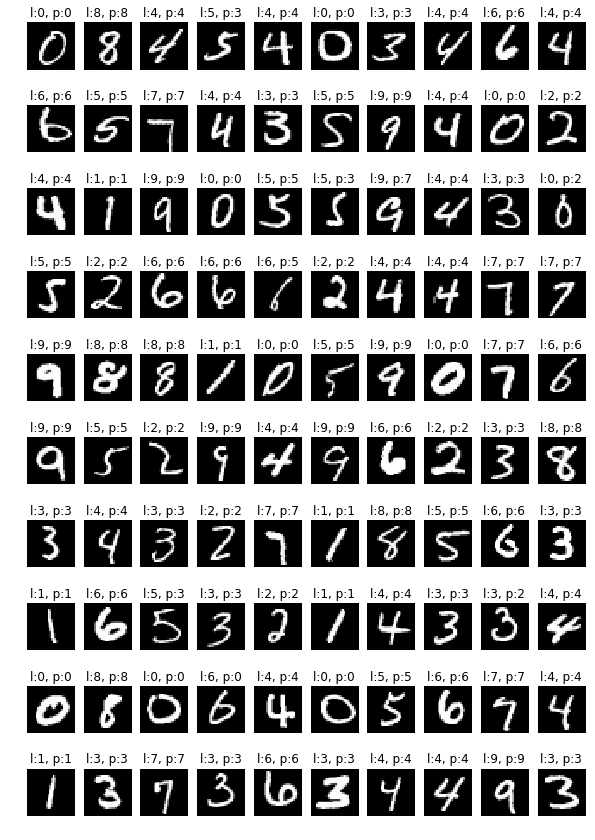

In [0]:
# Visualize Predictions
def view_predictions(images, labels, predictions):
    fig, axs = plt.subplots(10, 10, figsize=(10, 15))
    flatted_axs = [item for one_ax in axs for item in one_ax]
    for ax, img, label, prediction in zip(flatted_axs, images, labels, predictions):
        ax.imshow(img)
        ax.set_title('l:{}, p:{}'.format(label, prediction))
        ax.axis('off')
    plt.show() 

def visualize_predictions(sess, inputs, model_spec):
    sess.run(model_spec['iterator_init_op'])
    predictions = model_spec['predictions']
    images = inputs['images']
    labels = inputs['labels']
    _images, _labels, _predictions = sess.run([images, labels, predictions])
    view_predictions(_images, _labels, _predictions)

visualize_predictions(sess, test_inputs, test_model_spec)

For more help getting started with TensorFlow check out our introduction: http://cs230.stanford.edu/blog/tensorflow/